In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import keras_tuner as kt

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X

X_train = reshape_data(X_train, y_train, lookback)
X_val = reshape_data(X_val, y_val, lookback)
X_test = reshape_data(X_test, y_test, lookback)
# Ensure y_train, y_val, y_test have the same batch size as X_train
y_train = y_train[:X_train.shape[0]]  # Trim to match batch size
y_val = y_val[:X_val.shape[0]]
y_test = y_test[:X_test.shape[0]]

# Now, reshape y_train to match (batch_size, time_steps, target_param_size)
y_train = np.tile(y_train[:, np.newaxis, :], (1, X_train.shape[1], 1))  # (batch_size, time_steps, target_param_size)
y_val = np.tile(y_val[:, np.newaxis, :], (1, X_val.shape[1], 1))
y_test = np.tile(y_test[:, np.newaxis, :], (1, X_test.shape[1], 1))

print(X_train.shape)  # Should be (batch_size, time_steps, input_features)
print(y_train.shape)  # Should be (batch_size, time_steps, target_param_size)

def build_rnn_model_tuner(hp):
    from tensorflow.keras import layers, models, optimizers, regularizers
    
    arch_dict = {'lstm': layers.LSTM, 'gru': layers.GRU, 'rnn': layers.SimpleRNN}
    arch = hp.Choice('arch', ['lstm', 'gru', 'rnn'])
    ANN = arch_dict[arch]

    # Define tunable hyperparameters
    n_units = hp.Int('n_units', min_value=16, max_value=128, step=16)
    kernel_reg = hp.Float('kernel_reg', min_value=0.0001, max_value=0.1, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    lr_rate = hp.Float('lr_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    rnn_cfg = {
        'units': n_units,
        'input_shape': (X_train.shape[1], X_train.shape[2]),
        'kernel_regularizer': regularizers.l2(kernel_reg),
        'dropout': dropout_rate,
        'recurrent_dropout': dropout_rate,
        'return_sequences': True
    }

    x = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    y = ANN(**rnn_cfg)(x)
    y = layers.GaussianNoise(0.01)(y)
    y = layers.TimeDistributed(layers.Dense(y_train.shape[2]))(y)

    model = models.Model(inputs=x, outputs=y)

    opt = optimizers.Adam(learning_rate=lr_rate)
    model.compile(optimizer=opt, loss='mse', metrics=[rmse])
    
    return model

# Define the tuner
tuner = kt.BayesianOptimization(
    build_rnn_model_tuner,
    objective='val_loss',
    max_trials=20,  # Number of different models to try
    executions_per_trial=1,  # Run each model once for evaluation
    directory='bayesian_tuning',
    project_name='rnn_hyperparam_optimization'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: n_units={best_hps.get('n_units')}, kernel_reg={best_hps.get('kernel_reg')}, dropout_rate={best_hps.get('dropout_rate')}, lr_rate={best_hps.get('lr_rate')}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Evaluate on test set
test_loss, test_rmse = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.6f}, Test RMSE: {test_rmse:.6f}')

# Save the best model
best_model.save('best_rnn_model.h5')

Trial 20 Complete [00h 02m 15s]
val_loss: 1.801588773727417

Best val_loss So Far: 1.7043043375015259
Total elapsed time: 00h 47m 26s
Best Hyperparameters: n_units=112, kernel_reg=0.00013714105304030397, dropout_rate=0.4, lr_rate=0.00124171909043214
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - loss: 0.1513 - rmse: 0.3805 - val_loss: 1.7165 - val_rmse: 1.2711
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - loss: 0.1026 - rmse: 0.3167 - val_loss: 1.8121 - val_rmse: 1.3083
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - loss: 0.1029 - rmse: 0.3169 - val_loss: 1.8635 - val_rmse: 1.3269
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 0.0989 - rmse: 0.3100 - val_loss: 1.7873 - val_rmse: 1.3000
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 0.0953 - rmse: 0.3046 - val_loss: 1.8069 - val_rmse: 1.3064
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 0.0894 - rmse: 0.2951 - val_loss: 1.8250 - val_rmse: 1.3137
Epoch 7/100
64/64 

Test Loss: 1.290079, Test RMSE: 1.115655


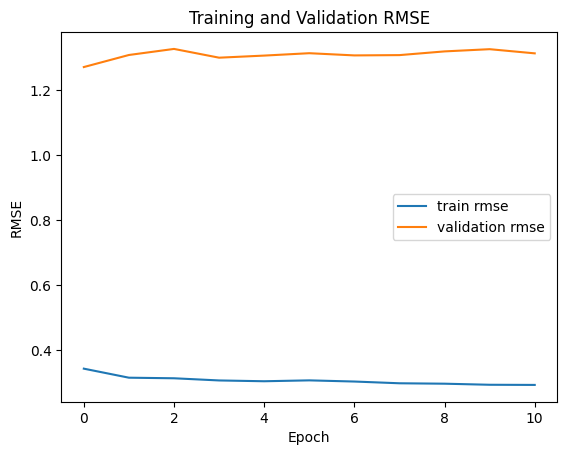

In [5]:
plt.figure()
plt.plot(history.history['rmse'], label='train rmse')
plt.plot(history.history['val_rmse'], label='validation rmse')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

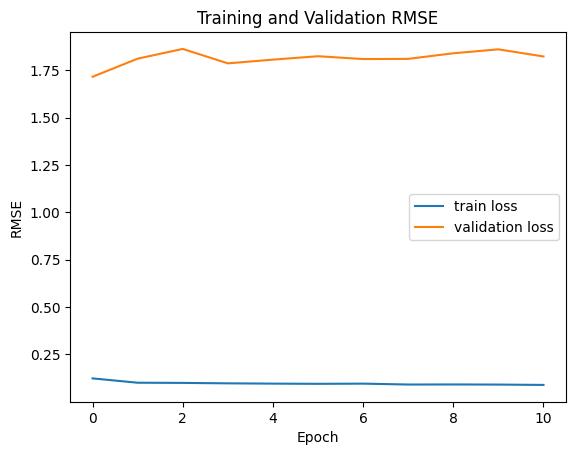

In [6]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()